In [1]:
%cd /Users/tqh7876/Library/CloudStorage/OneDrive-Takeda/ActiveProjects/WearableSimulations/code/quantitative-sciences-nt1-detection-wearable-simulation/
%load_ext autoreload
%autoreload 2

import os
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from src.vis.confusion_matrix import plot_cm
from pathlib import Path
from dataclasses import dataclass
from joblib import Parallel, delayed
from tqdm import tqdm

/Users/tqh7876/Library/CloudStorage/OneDrive-Takeda/ActiveProjects/WearableSimulations/code/quantitative-sciences-nt1-detection-wearable-simulation


In [2]:
version = '2025_09_20'
save_dir = Path('./export') / version / 'results' / 'mcmc'

%mkdir -p {save_dir}

In [3]:
@dataclass
class MCMC_Dataset:
    initial_distribution: np.array
    transition_matrix: np.array

    def __post_init__(self):
        self.initial_distribution = self._normalize_initial_distribution(self.initial_distribution)
        self.transition_matrix = self._normalize_transition_matrix(self.transition_matrix)
        assert self.initial_distribution.shape[0] == self.transition_matrix.shape[0], "Initial distribution and transition matrix size mismatch"

    def _normalize_initial_distribution(self, initial_distribution):
        id = np.array(initial_distribution)
        id_norm = id / id.sum()
        return id_norm

    def _normalize_transition_matrix(self, transition_matrix):
        tm = np.array(transition_matrix)
        tm_norm = tm / tm.sum(axis=1, keepdims=True)
        # assert tm_norm[0] == tm_norm.shape[1], "Transition matrix must be square"
        return tm_norm

    def _single_chain_run(self, initial_distribution, transition_matrix, choices, n_steps):
        current_state = np.random.choice(choices, p=initial_distribution)
        states = [current_state]
        for _ in range(n_steps - 1):
            current_state = np.random.choice(choices, p=transition_matrix[current_state])
            states.append(current_state)
        return np.array(states)

    def run_MCMC(self, N: int, n_steps: int):
        choices = np.arange(len(self.initial_distribution))
        all_states = Parallel(n_jobs=-1)(delayed(self._single_chain_run)(
            self.initial_distribution, 
            self.transition_matrix, 
            choices, 
            n_steps
        ) for _ in tqdm(range(N), desc="Processing MCMC in parallel"))

        return np.array(all_states)


In [4]:
# create dataframes

approaches = [
    {
        'name': 'Multi-feature',
        'datasets': [
            {'Dx': 'control', 'method': 'multi', 'dataset': 'NSRR', 'nights': 2, 'id': [4823, 63], 'tm': [[4601, 61], [61, 9]]},
            {'Dx': 'NT1', 'method': 'multi', 'dataset': 'comb', 'nights': 2, 'id': [49, 92], 'tm': [[7, 2.5], [2.5, 6]]}
        ]
    }, 
    {
        'name': 'SOREMP',
        'datasets': [
            {'Dx': 'control', 'method': 'soremps', 'dataset': 'NSRR', 'nights': 2, 'id': [4805, 81], 'tm': [[4580, 74], [74, 4]]},
            {'Dx': 'NT1', 'method': 'soremps', 'dataset': 'TAK-all', 'nights': 2, 'id': [56, 85], 'tm': [[8, 2.5], [2.5, 5]]}
        ]
    }
]

# parameters
realizations = 1000_000
recordings = 14
df_1 = pd.DataFrame()

for approach in approaches:
    for dataset in approach['datasets']:
        
        # run MCMC
        MCMC_Dataset_instance = MCMC_Dataset(initial_distribution=dataset['id'], transition_matrix=dataset['tm'])
        x = MCMC_Dataset_instance.run_MCMC(N=realizations, n_steps=recordings)

        # append to dataframe
        for recording in range(1, recordings+1): 
            df_new = pd.DataFrame.from_dict({
                'approach': approach['name'],
                'Dx': dataset.get('Dx'),
                'method': dataset.get('method'),
                'dataset': dataset.get('dataset'),
                'n_recs': recording,
                'n_pos_recs': x[:, :recording].sum(axis=1)
            })
            df_1 = pd.concat([df_1, df_new], ignore_index=True)

print(df_1['approach'].unique())
df_1.head()

Processing MCMC in parallel: 100%|██████████| 1000000/1000000 [00:14<00:00, 71340.70it/s]


['Multi-feature' 'SOREMP']


,approach,Dx,method,dataset,n_recs,n_pos_recs
0,Multi-feature,control,multi,NSRR,1,0
1,Multi-feature,control,multi,NSRR,1,0
2,Multi-feature,control,multi,NSRR,1,0
3,Multi-feature,control,multi,NSRR,1,0
4,Multi-feature,control,multi,NSRR,1,0


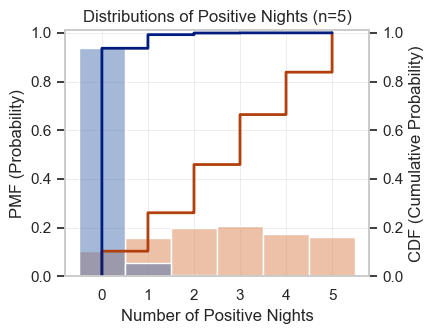

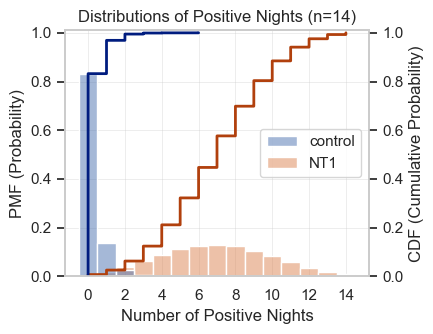

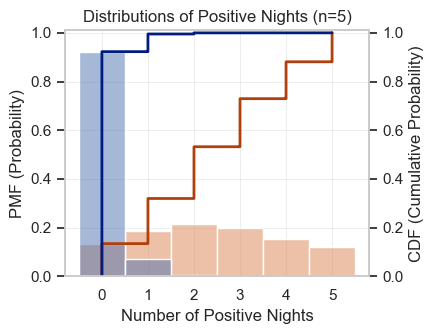

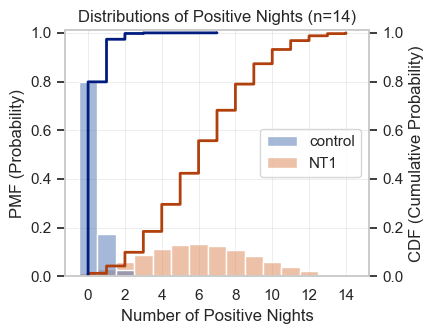

In [5]:
sns.set(style='whitegrid')


# parameters
n_recs_all = [5, 14]


for approach in ['Multi-feature', 'SOREMP']:
    for i, n_recs in enumerate(n_recs_all):
        # filter data
        df_ = df_1.query("(approach == @approach) & (n_recs == @n_recs)").copy()
        
        # figure
        fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))

        sns.histplot(
            data=df_,
            x='n_pos_recs',
            hue='Dx',
            hue_order=['control', 'NT1'],
            ax=ax,
            stat='probability',  # normalize
            common_norm=False,   # don't normalize across all hue groups
            multiple='layer',    # side-by-side bars like countplot
            shrink=1,          # optional: shrink bar width for spacing
            discrete=True        # ensure bars don't overlap if feature is discrete
        )

        ax.set_xlabel("Number of Positive Nights")
    
        ax.set_ylabel("PMF (Probability)")
        ax.set_title(f"Distributions of Positive Nights (n={n_recs})")
        ax.set_ylim(0, 1.01)
        #ax.grid(True, alpha=0.3)
        ax.grid(True, which='major', axis='both', linestyle='-', linewidth=0.5, alpha=0.5)
        # xticks
        max_ticks = 8
        xticks = np.linspace(0, n_recs, num=min(max_ticks, n_recs+1), dtype=int)
        ax.set_xticks(xticks)

        ax2 = ax.twinx()
        sns.ecdfplot(
            data=df_,
            x='n_pos_recs',
            hue='Dx',
            hue_order=['control', 'NT1'],
            ax=ax2,
            # weights="weight",
            palette='dark',
            lw=2
        )
        ax2.set_ylabel("CDF (Cumulative Probability)")
        ax2.set_ylim(0, 1.01)
        ax2.grid(False)
        
        # Legends: keep only one combined legend on the right-most panel
        leg1 = ax.get_legend()
        if leg1:
            if i == len(n_recs_all) - 1:
                leg1.set_title(None)
                leg1.set_loc("center right")
            else:
                leg1.remove()

        leg2 = ax2.get_legend()
        if leg2:
            leg2.remove()

        plt.tight_layout()

        plt.savefig(save_dir / f"mcmc_{approach}_n={n_recs}.png", dpi=600, bbox_inches='tight')
        plt.savefig(save_dir / f"mcmc_{approach}_n={n_recs}.svg", bbox_inches='tight')

    

In [6]:
def compute_confusion_matrix(y_true, y_pred, prevalence=1/2048):
    tp = round(((y_pred == 1) & (y_true == 1)).sum() * prevalence)
    tn = round(((y_pred == 0) & (y_true == 0)).sum() * (1 - prevalence))
    fp = round(((y_pred == 1) & (y_true == 0)).sum() * (1 - prevalence))
    fn = round(((y_pred == 0) & (y_true == 1)).sum() * prevalence)
    
    return tp, tn, fp, fn

def compute_metrics(y_true, y_pred, prevalence):

    tp, tn, fp, fn = compute_confusion_matrix(y_true=y_true, y_pred=y_pred, prevalence=prevalence)
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    fp_tp_ratio = fp / tp if tp > 0 else np.inf
    f1 = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else np.nan
    
    return {'Sensitivity': sensitivity, 'Specificity': specificity, 'PPV': ppv, 'FP:TP': fp_tp_ratio, 'F1 score': f1}



In [7]:
# parameters
prevalence=1/2048 # TODO - update prevalence
thresholds = [1, 2, 3, 4, 5]
thresholds = 5
n_recordings = 14

metrics = []
for approach in ['Multi-feature', 'SOREMP']:
    for n_rec in range(1, recordings+1):
        # filter data
        df_ = df_1.query("(approach == @approach) & (n_recs == @n_rec)").copy()
        y = df_['Dx'].map({'control': 0, 'NT1': 1}).values
        
        for thresh in range(1, min(n_rec+1, thresholds + 1)):
            
            # apply threshold
            p_bin = (df_['n_pos_recs'].values >= thresh).astype(int)

            # compute metrics
            metrics.append({
                'approach': approach,
                'Recordings (n)': n_rec,
                'Min. required positive (n)': thresh,
                **compute_metrics(y_true=y, y_pred=p_bin, prevalence=prevalence)
            })

df_metrics = pd.DataFrame(metrics)
df_metrics.head(28)


,approach,Recordings (n),Min. required positive (n),Sensitivity,Specificity,PPV,FP:TP,F1 score
0,Multi-feature,1,1,0.651639,0.987113,0.024093,40.506289,0.046467
1,Multi-feature,2,1,0.743852,0.974281,0.013925,70.815427,0.027337
2,Multi-feature,2,2,0.459016,0.998319,0.117647,7.500000,0.187291
3,Multi-feature,3,1,0.811475,0.961705,0.010240,96.656566,0.020225
4,Multi-feature,3,2,0.574642,0.996530,0.074953,12.341637,0.132610
5,Multi-feature,3,3,0.323770,0.999788,0.427027,1.341772,0.368298
6,Multi-feature,4,1,0.860656,0.949047,0.008179,121.257143,0.016205
7,Multi-feature,4,2,0.665984,0.994623,0.057028,16.535385,0.105059
8,Multi-feature,4,3,0.440574,0.999532,0.314788,2.176744,0.367208
9,Multi-feature,4,4,0.229039,0.999969,0.783217,0.276786,0.354430


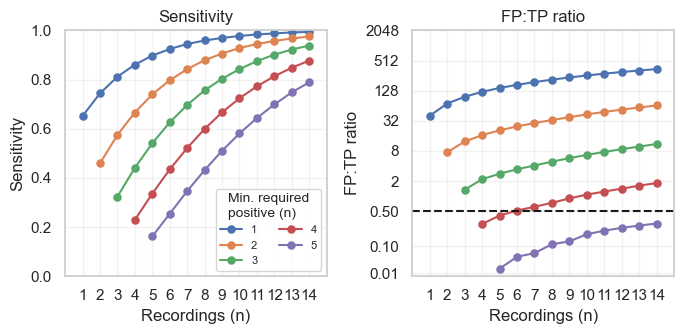

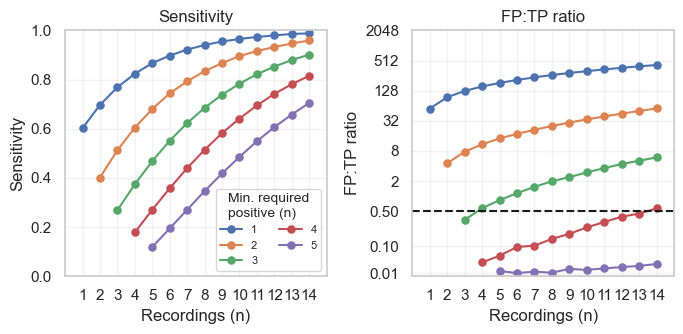

In [8]:
for approach in ['Multi-feature', 'SOREMP']:

    df_ = df_metrics.query("approach == @approach").copy()

    # Create plots
    fig, axes = plt.subplots(ncols=2, figsize=(7, 3.5))

    # Sensitivity plot
    sns.pointplot(data=df_, hue='Min. required positive (n)', y='Sensitivity', x='Recordings (n)', palette='deep', ax=axes[0], markers='o', ms=5, lw=1.5)
    axes[0].set_title('Sensitivity')
    axes[0].set_ylabel('Sensitivity')
    axes[0].grid(True, alpha=0.25)
    axes[0].set_ylim([0, 1])
    axes[0].set_xlim([-1, recordings])
    axes[0].legend().remove()
    axes[0].legend(title='Min. required\npositive (n)', loc='lower right', ncols=2, fontsize=8, title_fontsize=10)

    # FP:TP Ratio plot
    sns.pointplot(data=df_, hue='Min. required positive (n)', y='FP:TP', x='Recordings (n)', palette='deep', ax=axes[1], markers='o', ms=5, lw=1.5)
    axes[1].set_title('FP:TP ratio')
    axes[1].set_ylabel('FP:TP ratio')
    axes[1].grid(True, alpha=0.25)
    # axes[1].axhline(y=max_FPTP, color='black', linestyle='--', label='Max FP:TP')

    ticks = [0.01, 0.1, 0.5, 2, 8, 32,  128,  512, 2048]
    axes[1].set_yscale('symlog', base=2, linthresh=0.1)
    axes[1].set_ylim([0, 2e3])
    axes[1].set_xlim([-1, recordings])
    axes[1].set_yticks(ticks)
    axes[1].set_yticklabels([f'{tick:.2f}' if tick < 1 else f'{tick}' for tick in ticks])
    axes[1].legend().remove()
    axes[1].axhline(0.5, ls='--', color='k')
    
    # F1 score plot
    # sns.pointplot(data=df_, hue='Min. required positive (n)', y='F1 score', x='Recordings (n)', palette='deep', ax=axes[2], markers='o', ms=5, lw=1.5)
    # # axes[2].set_title(f'F1 score (FP:TP < {max_FPTP:.1f})')
    # axes[2].set_ylabel('F1 score')
    # axes[2].grid(True, alpha=0.25)
    # axes[2].set_ylim([0, 1])
    # axes[2].set_xlim([-1, recordings])
    # axes[2].legend().remove()
    # #axes[2].legend(title='Min. required positive (n)', loc='upper left', ncols=2, fontsize=8)

    plt.tight_layout()

    plt.savefig(save_dir / f"mcmc_{approach}_SeSp.png", dpi=600, bbox_inches='tight')
    plt.savefig(save_dir / f"mcmc_{approach}_SeSp.svg", bbox_inches='tight')

In [ ]:
for nt1s, mean p = 